In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
import seaborn as sns
from cdcp.visualization.colors import colors as cdcp_colors
%matplotlib inline

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [421]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [101]:
import numpy as np
from lmfit import Model
import lmfit
from sklearn.metrics.pairwise import cosine_similarity


def gaussian(x, mu=0, sig=1):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sig, 2.0)))


def bayesian_model(
    params,
    x_true,
    prior_probability,
    decision_boundary,
    prior_modulated_likelihood=False,
    likelihood_constant=10,
):
    """
    gamma: the side biases of the bird
    sigma: sigma of the likelihood gaussian
    delta: the overall innattentivity to cue stimuli
    alpha: the overall innattentivity all stimuli
    beta: the overall innattentivity to the categorical stimuli
    Parameters
    ----------
    params : [type]
        [description]
    x_true : [type]
        [description]
    prior_probability : [type]
        [description]
    decision_boundary : [type]
        [description]

    Returns
    -------
    [type]
        [description]
    """
    side_bias = (decision_boundary * (1 - ((1 - params["gamma_side_bias"]) * 2))) + (
        1 - params["gamma_side_bias"]
    )
    side_bias = side_bias / np.sum(side_bias)  # normalize the side bias

    # the likelihood is list of gaussians centered around x_true (the interpolation point)
    # .  at for each value of x_true

    # modulate likelihood based on prior
    if prior_modulated_likelihood:
        likelihoods = [
            params["sigma_likelihood"]
            * (-np.log(prior_probability[i]))
            / likelihood_constant
            for i, x_i in enumerate(x_true)
        ]
        likelihood = np.array(
            [
                gaussian(x_true, x_i, l)
                for i, (x_i, l) in enumerate(zip(x_true, likelihoods))
            ]
        )
    else:
        likelihood = np.array(
            [gaussian(x_true, x_i, params["sigma_likelihood"]) for x_i in x_true]
        )
    likelihood = np.array(
        [i / np.sum(i) for i in likelihood]
    )  # normalize likelihood gaussian to sum to 1

    likelihood = np.array(
        [
            (1 - params["beta_categorical_attention"]) * i
            + params["beta_categorical_attention"] * side_bias
            for i in likelihood
        ]
    )
    likelihood = np.array(
        [i / np.sum(i) for i in likelihood]
    )  # normalize full likelihood to sum to 1

    # calculate the bias of the prior probability
    prior_probability = (
        1.0 - params["delta_cue_attention"]
    ) * prior_probability + side_bias * params["delta_cue_attention"]

    # calculate the posterior probability
    posterior_probability = likelihood * prior_probability
    posterior_probability = np.array(
        [i / np.sum(i) for i in posterior_probability]
    )  # normalize posterior probability to sum to 1
    # posterior_probability = params['alpha']*posterior_probability+((1.-params['alpha'])*params['gamma'])
    posterior_probability = (
        1.0 - params["alpha_overall_attention"]
    ) * posterior_probability + ((params["alpha_overall_attention"]) * side_bias)
    posterior_probability = np.array(
        [i / np.sum(i) for i in posterior_probability]
    )  # normalize posterior probability to sum to 1

    # make a decision
    decision = np.sum([i * decision_boundary for i in posterior_probability], axis=1)

    likelihood_similarity = cosine_similarity(likelihood)
    posterior_similarity = cosine_similarity(posterior_probability)

    return (
        decision,
        posterior_probability,
        likelihood,
        likelihood_similarity,
        posterior_similarity,
    )

In [102]:
def quick_sketch_integration(
    prior_probability,
    decision,
    posterior_probability,
    likelihood,
    likelihood_similarity,
    posterior_similarity,
    x_true, 
    x_true_bds,
    x_stack
):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
    ax = axs.flatten()[0]
    ax.set_title("Prior")
    ax.plot(x_true[bds[0] : bds[1]], prior_probability[bds[0] : bds[1]])

    ax = axs.flatten()[1]
    ax.set_title("Likelihood")
    ax.matshow(likelihood[bds[0] : bds[1], bds[0] : bds[1]], aspect="auto")

    ax = axs.flatten()[2]
    ax.set_title("posterior")
    ax.matshow(posterior_probability[bds[0] : bds[1], bds[0] : bds[1]], aspect="auto")

    ax = axs.flatten()[3]
    ax.set_title("Actual vs perceived stimulus")
    subsamp = 5
    for i in x_stack[::subsamp]:
        ax.plot(i, [1, 0], color="k")
    ax.set_xlim([x_true_bds[0], x_true_bds[1]])
    # axs[0].axis('off')

    ax = axs.flatten()[4]
    ax.set_title("Similarity of likelihood")
    ax.matshow(likelihood_similarity[bds[0] : bds[1], bds[0] : bds[1]], aspect="auto")

    ax = axs.flatten()[5]
    ax.set_title("Similarity of posterior")
    ax.matshow(posterior_similarity[bds[0] : bds[1], bds[0] : bds[1]], aspect="auto")

    ax = axs.flatten()[6]
    ax.set_title("Decision")
    ax.plot(x_true[bds[0] : bds[1]], decision[bds[0] : bds[1]])

    ax = axs.flatten()[7]
    ax.set_title("Likelihood")
    for i in likelihood[bds[0] : bds[1]][::20]:
        ax.plot(x_true, i, color="k", lw=3)
    ax.set_xlim([x_true_bds[0], x_true_bds[1]])

    ax = axs.flatten()[8]
    ax.set_title("Posterior")
    for i in posterior_probability[bds[0] : bds[1]][::20]:
        ax.plot(x_true, i, color="k", lw=3)
    ax.set_xlim([x_true_bds[0], x_true_bds[1]])
    plt.tight_layout()

### default single prior distribution

In [103]:
params = {
    'sigma_likelihood':20, # std of gaussian for likelihood
    'beta_categorical_attention': 0, # pct of time ignoring the categorical stimulus # if set at 0 all guesses are based upon the cue, 
    'delta_cue_attention':0, # pct of time ignoring the cue
    'alpha_overall_attention':0, # pct of time ingoring both the cue, and categorical stimulis, independant of the product of beta and delta 
    'gamma_side_bias': .5 # the direction of the random guess (side bias)
}

In [104]:
x_true = np.arange(-200, 200)
half = int(len(x_true)/2)
decision_boundary = np.concatenate([np.zeros(half), np.ones(half)])
bds = [half-64, half+64]
x_true_bds = [x_true[half]-64, x_true[half]+64]
prior_probability = gaussian(x_true, np.mean(x_true), 20)
prior_probability = prior_probability/np.sum(prior_probability)
decision, posterior_probability, likelihood, likelihood_similarity, posterior_similarity = bayesian_model(
    params, x_true, prior_probability, decision_boundary
)
x_shift = [np.mean(i*x_true)*len(x_true) for i in posterior_probability]
x_stack = np.stack([x_true, x_shift]).T

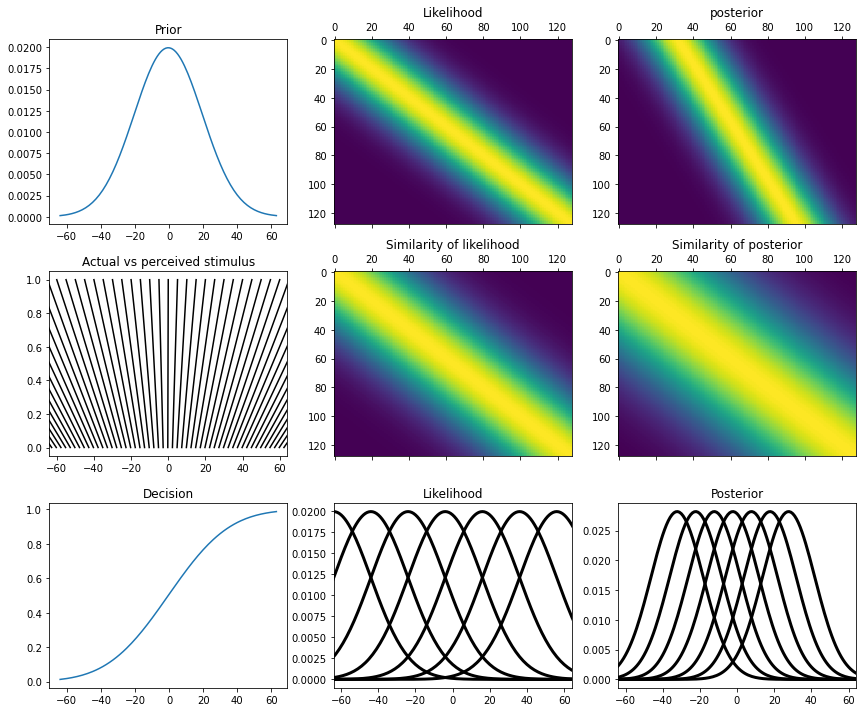

In [105]:
quick_sketch_integration(
    prior_probability,
    decision,
    posterior_probability,
    likelihood,
    likelihood_similarity,
    posterior_similarity,
    x_true, 
    x_true_bds,
    x_stack
)

##### modulate prior by likelihood

In [106]:
prior_probability = prior_probability/np.sum(prior_probability)
decision, posterior_probability, likelihood, likelihood_similarity, posterior_similarity = bayesian_model(
    params, x_true, prior_probability, decision_boundary, prior_modulated_likelihood=True
)
x_shift = [np.mean(i*x_true)*len(x_true) for i in posterior_probability]
x_stack = np.stack([x_true, x_shift]).T

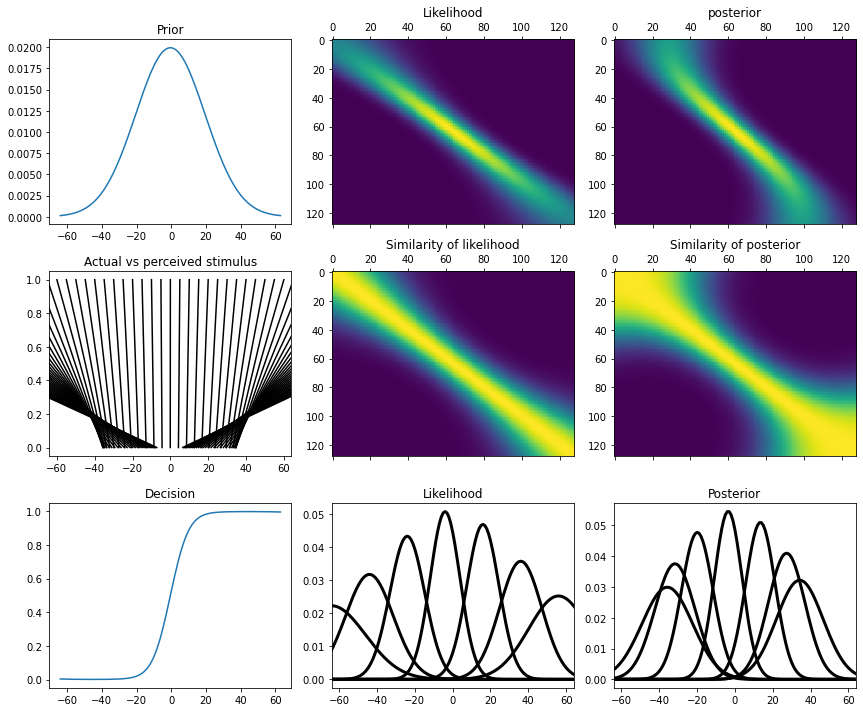

In [107]:
quick_sketch_integration(
    prior_probability,
    decision,
    posterior_probability,
    likelihood,
    likelihood_similarity,
    posterior_similarity,
    x_true, 
    x_true_bds,
    x_stack
)

### Two gaussian distributions

In [223]:
x_true = np.arange(-200, 200)
half = int(len(x_true)/2)
decision_boundary = np.concatenate([np.zeros(half), np.ones(half)])
bds = [half-64, half+64]
x_true_bds = [x_true[half]-64, x_true[half]+64]
prior_probability1 = gaussian(x_true, np.mean(x_true)-50, 20)
prior_probability2 = gaussian(x_true, np.mean(x_true)+50, 20)
prior_probability = prior_probability1 + prior_probability2
prior_probability = prior_probability/np.sum(prior_probability)

In [224]:
decision, posterior_probability, likelihood, likelihood_similarity, posterior_similarity = bayesian_model(
    params, x_true, prior_probability, decision_boundary
)
x_shift = [np.mean(i*x_true)*len(x_true) for i in posterior_probability]
x_stack = np.stack([x_true, x_shift]).T

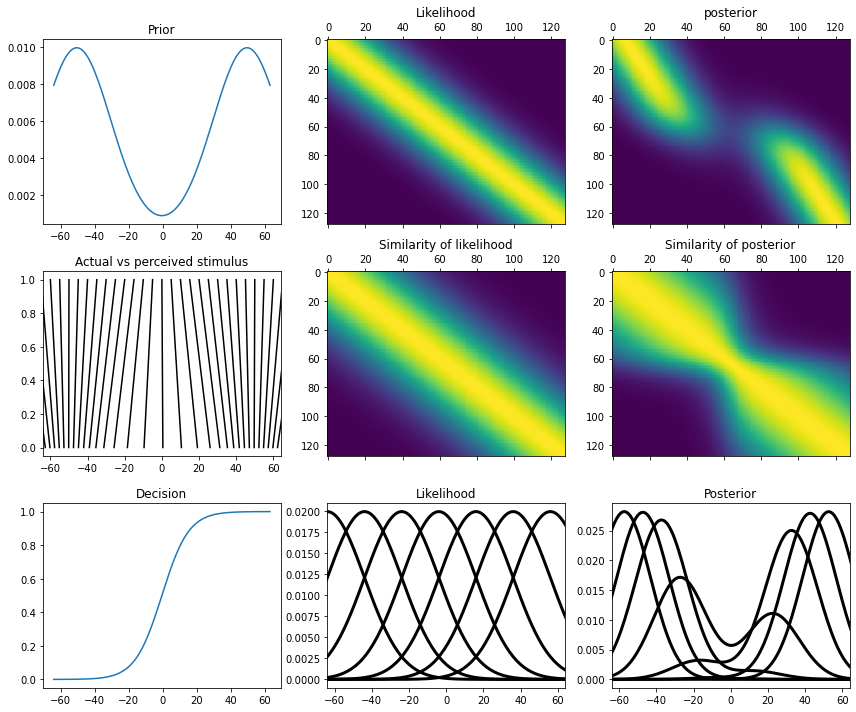

In [225]:
quick_sketch_integration(
    prior_probability,
    decision,
    posterior_probability,
    likelihood,
    likelihood_similarity,
    posterior_similarity,
    x_true, 
    x_true_bds,
    x_stack
)

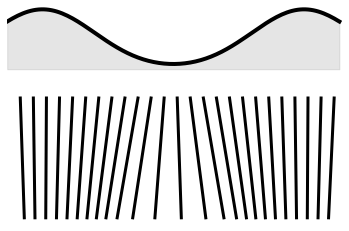

In [429]:
fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1, 2]})
ax = axs[0]
ax.plot(x_true[bds[0] : bds[1]], prior_probability[bds[0] : bds[1]], color = 'k', lw = 4)

ax.fill_between(
    x_true[bds[0] : bds[1]],
    np.zeros(len(prior_probability[bds[0] : bds[1]])),
    prior_probability[bds[0] : bds[1]],
    color="k",
    alpha=0.1,
)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis('off')

ax = axs[1]
subsamp = 5
ls = x_stack[bds[0] : bds[1]][::subsamp]
m = ((ls[:, 0] > x_true_bds[0]) & (ls[:, 0] < x_true_bds[1]))
ls = ls[m]
pal = sns.color_palette('viridis', len(ls))
for i, si in enumerate(ls):
    if (si[0] < x_true_bds[0]) or (si[0] > x_true_bds[1]):
        continue
    ax.plot(si, [1, 0], color='k', lw=3)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis('off')

ensure_dir(FIGURE_DIR / 'likelihood_model')
if save_figs:
    save_fig(FIGURE_DIR / 'likelihood_model'/ 'posterior_gaussian', save_pdf=True)
plt.show()

##### modulate prior by likelihood

In [234]:
prior_probability = prior_probability/np.sum(prior_probability)
decision, posterior_probability, likelihood, likelihood_similarity, posterior_similarity = bayesian_model(
    params, x_true, prior_probability, decision_boundary, prior_modulated_likelihood=True
)
x_shift = [np.mean(i*x_true)*len(x_true) for i in posterior_probability]
x_stack = np.stack([x_true, x_shift]).T

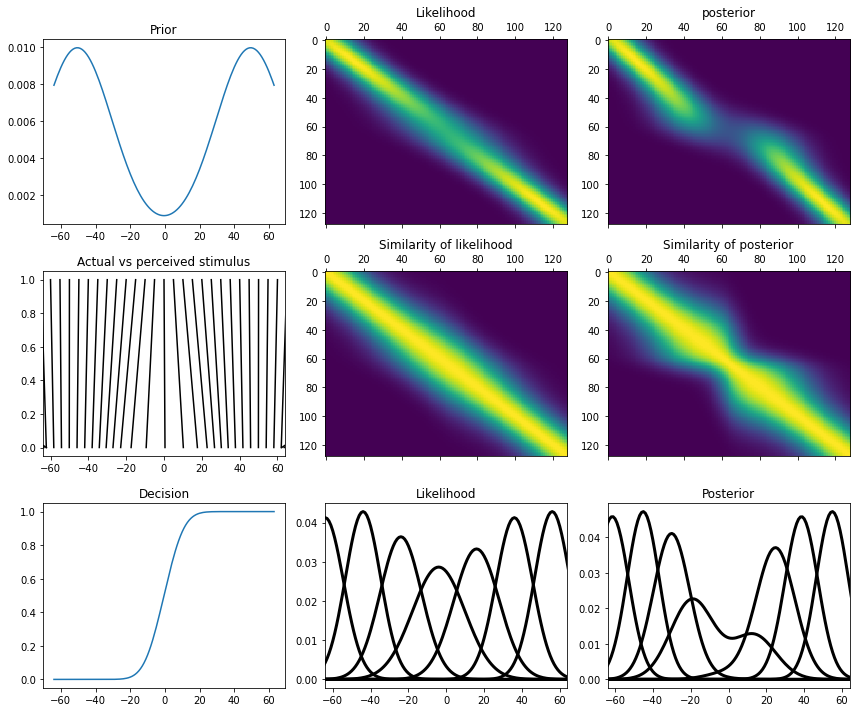

In [235]:
quick_sketch_integration(
    prior_probability,
    decision,
    posterior_probability,
    likelihood,
    likelihood_similarity,
    posterior_similarity,
    x_true, 
    x_true_bds,
    x_stack
)

In [252]:
import seaborn as sns

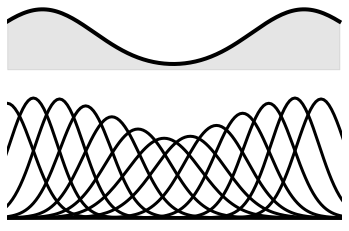

In [428]:
fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1, 2]})

ax = axs[0]
ax.plot(x_true[bds[0] : bds[1]], prior_probability[bds[0] : bds[1]], color="k", lw=4)
ax.fill_between(
    x_true[bds[0] : bds[1]],
    np.zeros(len(prior_probability[bds[0] : bds[1]])),
    prior_probability[bds[0] : bds[1]],
    color="k",
    alpha=0.1,
)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis('off')

ax = axs[1]
subsamp = 10
ls = likelihood[bds[0] : bds[1]][::subsamp]
pal = sns.color_palette('viridis', len(ls))
for i, lsi in enumerate(ls):
    ax.plot(x_true, lsi, lw=3, color ='k')
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis('off')

ensure_dir(FIGURE_DIR / 'likelihood_model')
if save_figs:
    save_fig(FIGURE_DIR / 'likelihood_model'/ 'likelihood_gaussian', save_pdf=True)
plt.show()

### step functions

In [113]:
probability_left_ranges = [0.125, 0.25, 0.5, 0.75, 0.875]

In [114]:
x_true = np.arange(-200, 200)
half = int(len(x_true)/2)
decision_boundary = np.concatenate([np.zeros(half), np.ones(half)])
bds = [half-64, half+64]
x_true_bds = [x_true[half]-64, x_true[half]+64]

0.125


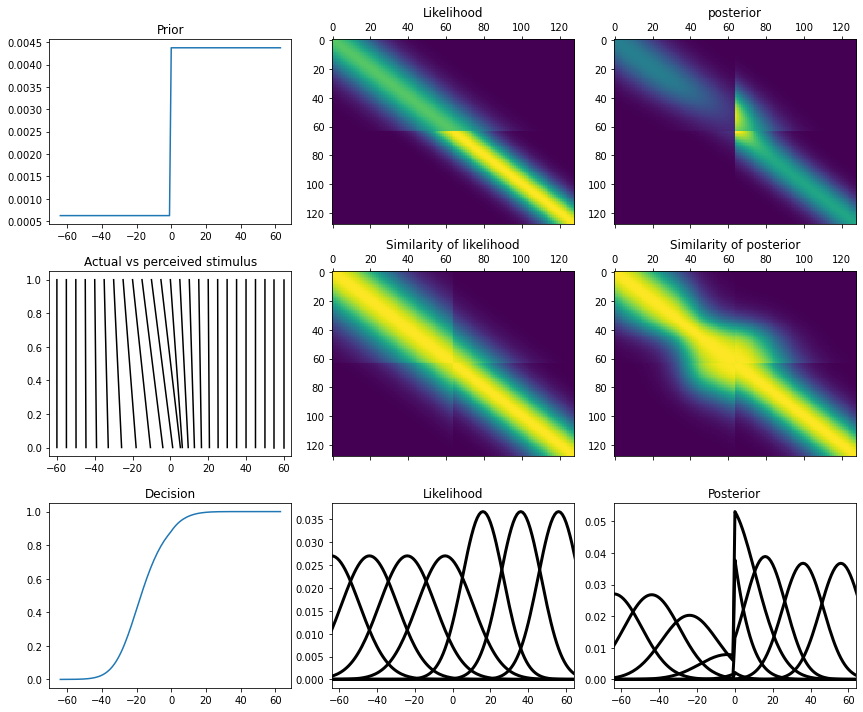

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


0.25


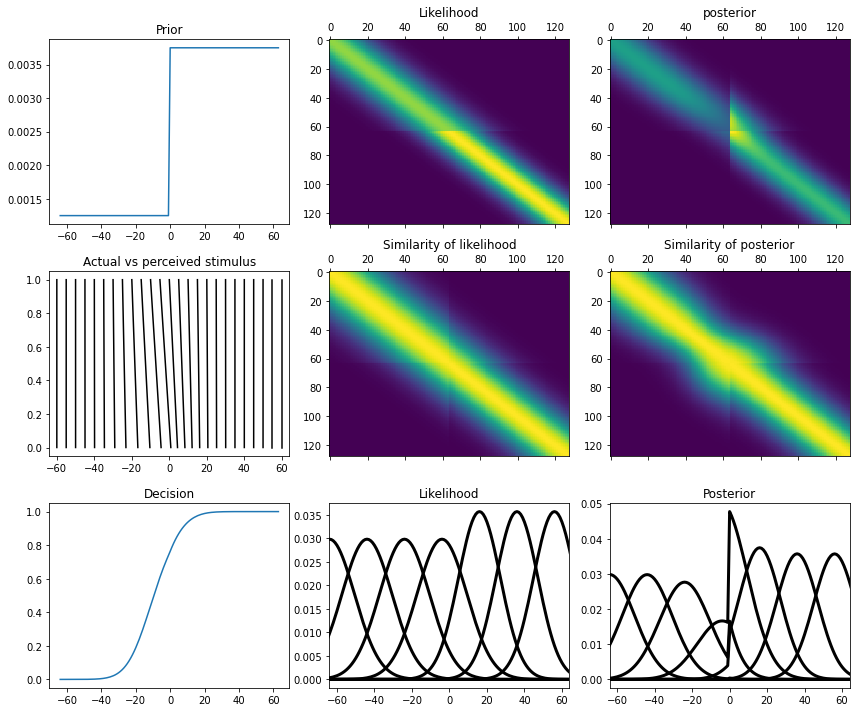

0.5


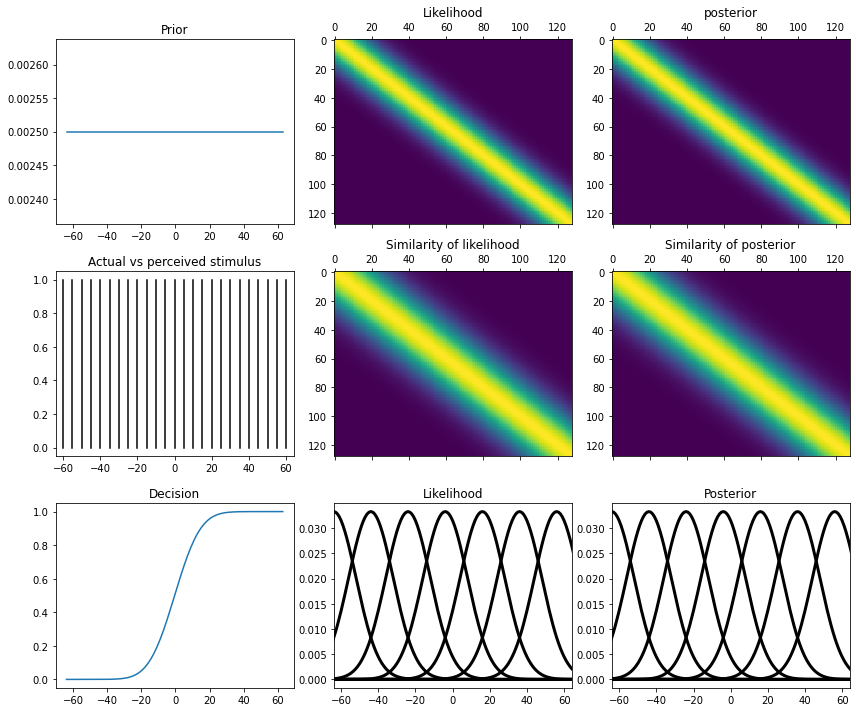

0.75


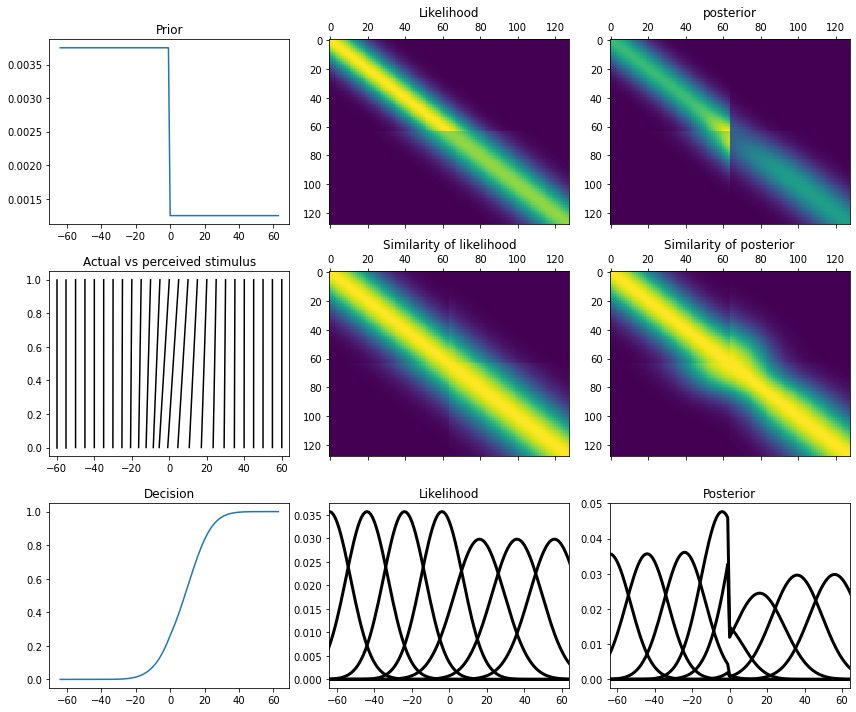

0.875


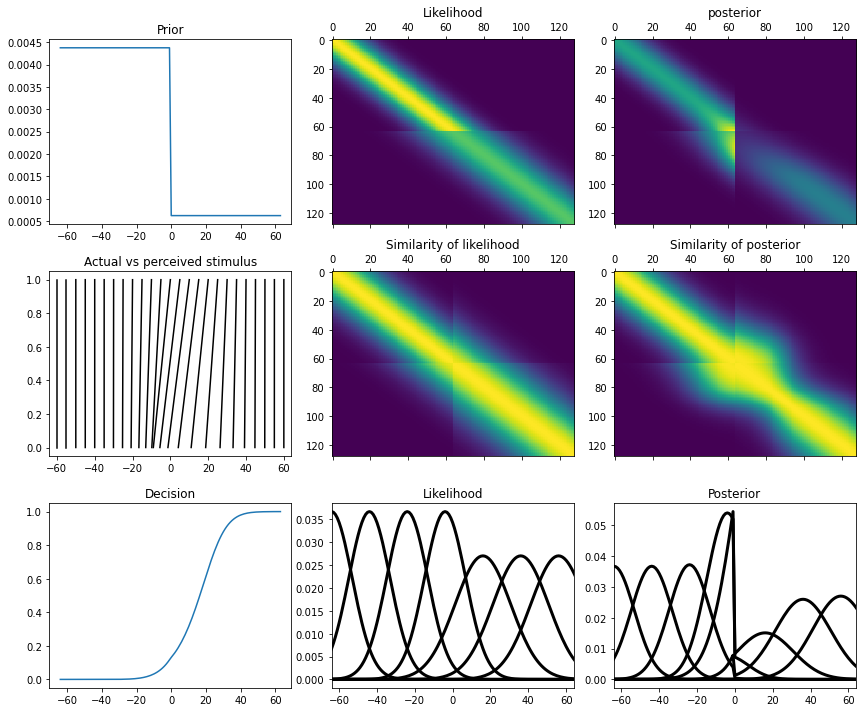

0.125


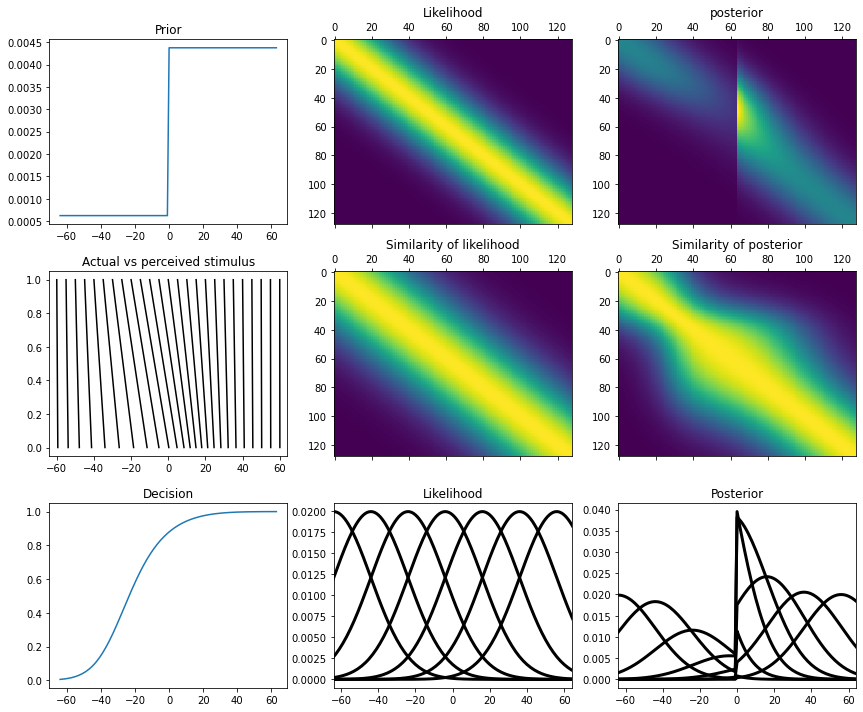

0.25


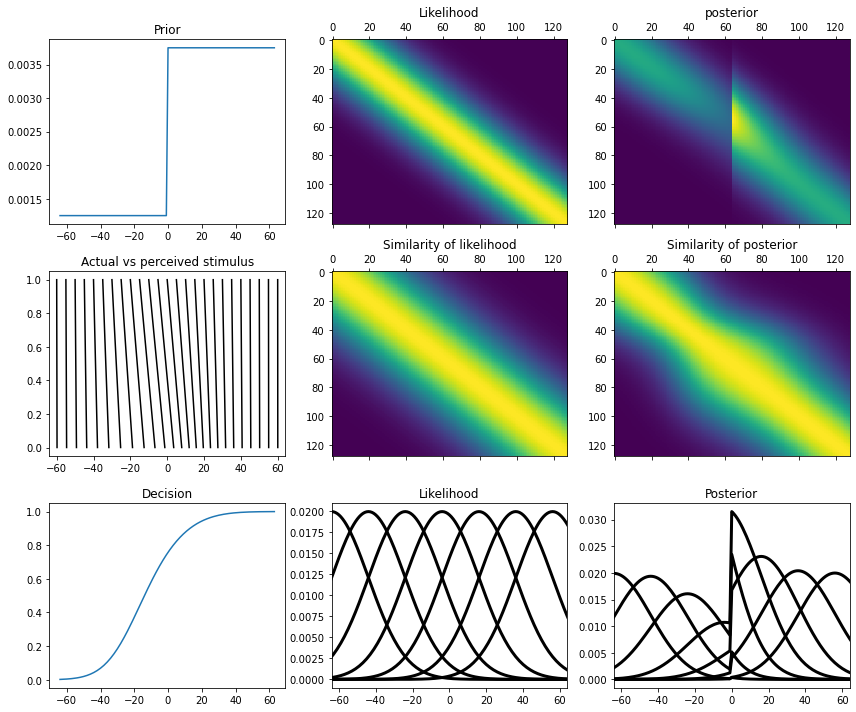

0.5


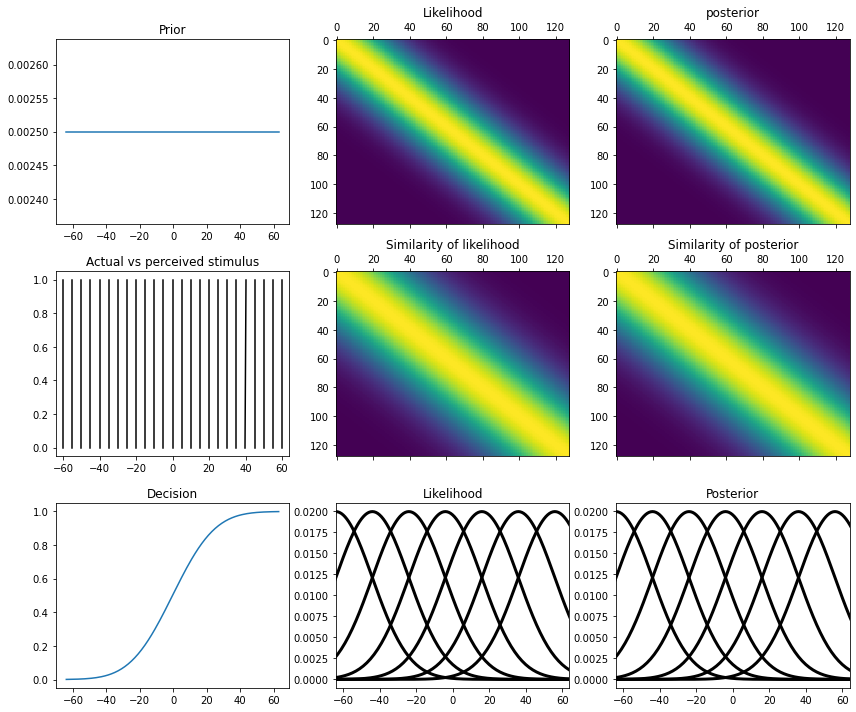

0.75


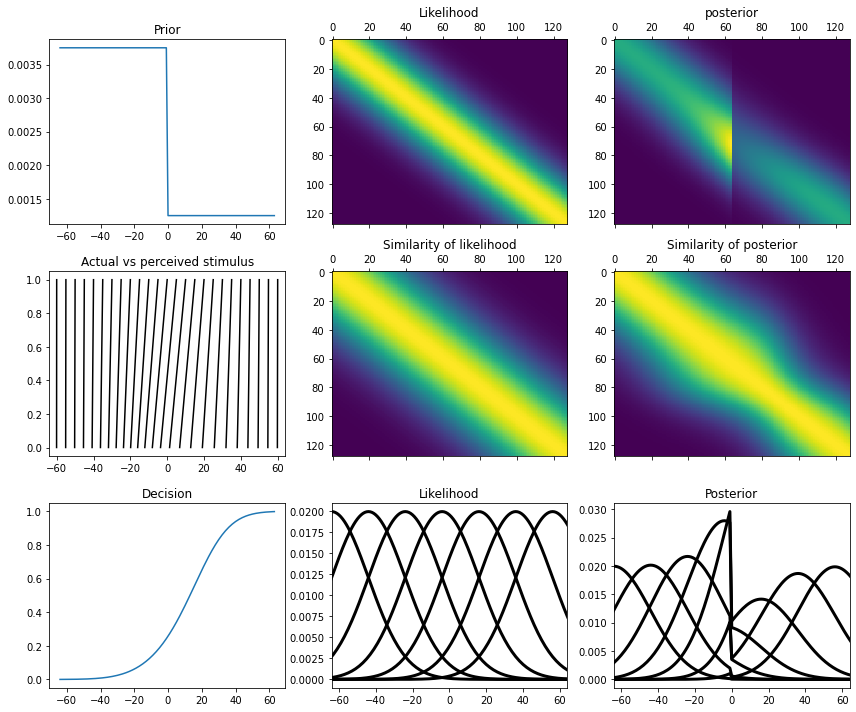

0.875


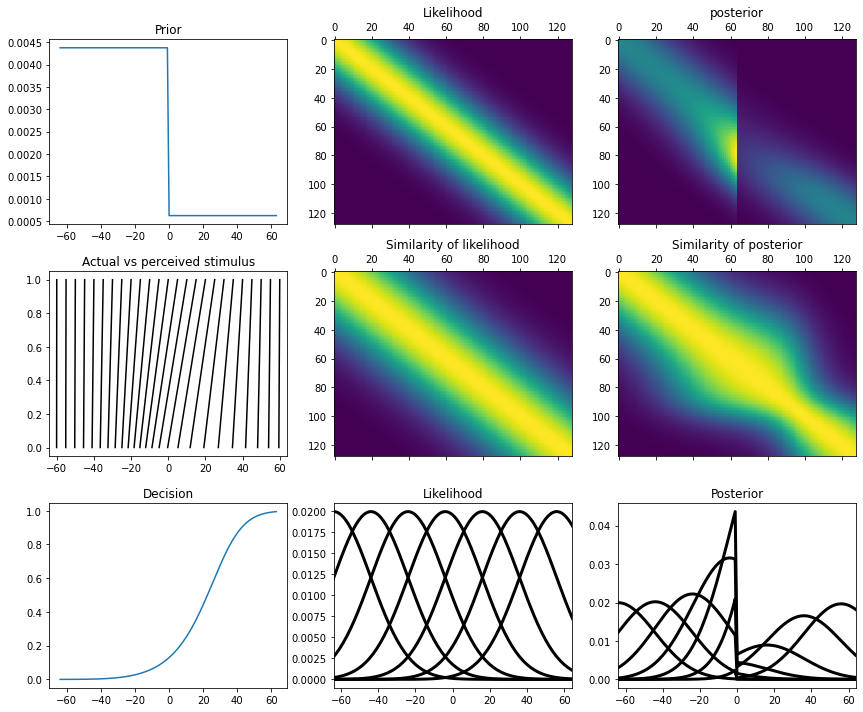

In [116]:
prob_df = pd.DataFrame(columns = [
    "p_left",
    "prior_probability",
    "decision",
    "posterior_probability",
    "likelihood",
    "likelihood_similarity",
    "posterior_similarity",
    "x_true", 
    "x_true_bds",
    "x_stack",
    "prior_modulated_likelihood"
])

for prior_modulated_likelihood in [True, False]:
    for p_left in probability_left_ranges:
        print(p_left)
        prior_probability = np.concatenate(
            [np.ones(half) * p_left, np.ones(half) * (1 - p_left)]
        )
        prior_probability = prior_probability / np.sum(prior_probability)

        decision, posterior_probability, likelihood, likelihood_similarity, posterior_similarity = bayesian_model(
            params, x_true, prior_probability, decision_boundary, prior_modulated_likelihood=prior_modulated_likelihood
        )
        x_shift = [np.mean(i*x_true)*len(x_true) for i in posterior_probability]
        x_stack = np.stack([x_true, x_shift]).T

        quick_sketch_integration(
            prior_probability,
            decision,
            posterior_probability,
            likelihood,
            likelihood_similarity,
            posterior_similarity,
            x_true, 
            x_true_bds,
            x_stack
        )
        plt.show()

        prob_df.loc[len(prob_df)] = [
            p_left,
            prior_probability,
            decision,
            posterior_probability,
            likelihood,
            likelihood_similarity,
            posterior_similarity,
            x_true, 
            x_true_bds,
            x_stack,
            prior_modulated_likelihood
        ]

In [117]:
prob_df

,p_left,prior_probability,decision,posterior_probability,likelihood,likelihood_similarity,posterior_similarity,x_true,x_true_bds,x_stack,prior_modulated_likelihood
0,0.125,"[0.000625, 0.000625, 0.000625, 0.000625, 0.000...","[7.804821004183249e-41, 1.8594348948735088e-40...","[[0.05265014759373285, 0.05252937674716312, 0....","[[0.052650147593732856, 0.052529376747163126, ...","[[1.0000000000000002, 0.9995587614259959, 0.99...","[[1.0, 0.9995587614259956, 0.9981849562867048,...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -188.5411190229687], [-199.0, -188.1...",True
1,0.250,"[0.00125, 0.00125, 0.00125, 0.00125, 0.00125, ...","[6.525548079607214e-50, 1.8885725499237236e-49...","[[0.05795140588203695, 0.057789518013224066, 0...","[[0.057951405882036955, 0.05778951801322406, 0...","[[1.0000000000000002, 0.999459477601738, 0.997...","[[1.0000000000000002, 0.9994594776017381, 0.99...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -189.64682028422015], [-199.0, -189....",True
2,0.500,"[0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.002...","[2.7648098258285257e-62, 1.0447763432550315e-6...","[[0.06443973908810857, 0.06421574225163106, 0....","[[0.06443973908810857, 0.06421574225163106, 0....","[[0.9999999999999998, 0.9993225279425012, 0.99...","[[0.9999999999999998, 0.9993225279425012, 0.99...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -190.75243171540754], [-199.0, -190....",True
3,0.750,"[0.00375, 0.00375, 0.00375, 0.00375, 0.00375, ...","[7.371576916160157e-72, 3.4178675064860733e-71...","[[0.06895589130392926, 0.06868020828378217, 0....","[[0.06895589130392926, 0.06868020828378217, 0....","[[1.0000000000000004, 0.9992168624089567, 0.99...","[[1.0000000000000004, 0.9992168624089569, 0.99...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -191.39911842560184], [-199.0, -191....",True
4,0.875,"[0.004375, 0.004375, 0.004375, 0.004375, 0.004...","[3.1327927804884977e-76, 1.5895691951334274e-7...","[[0.07084347675681363, 0.07054397808140554, 0....","[[0.07084347675681363, 0.07054397808140554, 0....","[[1.0000000000000004, 0.9991701205269532, 0.99...","[[1.0000000000000004, 0.9991701205269531, 0.99...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -191.64496440025476], [-199.0, -191....",True
5,0.125,"[0.000625, 0.000625, 0.000625, 0.000625, 0.000...","[1.3318756723392971e-22, 2.118691056929636e-22...","[[0.039114016297278516, 0.0390651543220037, 0....","[[0.039114016297278516, 0.0390651543220037, 0....","[[0.9999999999999999, 0.9997632536625033, 0.99...","[[0.9999999999999998, 0.9997632536625033, 0.99...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -184.35765339000568], [-199.0, -183....",False
6,0.250,"[0.00125, 0.00125, 0.00125, 0.00125, 0.00125, ...","[5.708038595739844e-23, 9.080104529698439e-23,...","[[0.039114016297278516, 0.0390651543220037, 0....","[[0.039114016297278516, 0.0390651543220037, 0....","[[0.9999999999999999, 0.9997632536625033, 0.99...","[[0.9999999999999998, 0.9997632536625033, 0.99...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -184.35765339000568], [-199.0, -183....",False
7,0.500,"[0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.002...","[1.9026795319132818e-23, 3.0267015098994797e-2...","[[0.039114016297278516, 0.0390651543220037, 0....","[[0.039114016297278516, 0.0390651543220037, 0....","[[0.9999999999999999, 0.9997632536625033, 0.99...","[[0.9999999999999998, 0.9997632536625033, 0.99...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -184.35765339000568], [-199.0, -183....",False
8,0.750,"[0.00375, 0.00375, 0.00375, 0.00375, 0.00375, ...","[6.3422651063776065e-24, 1.0089005032998267e-2...","[[0.03911401629727851, 0.0390651543220037, 0.0...","[[0.039114016297278516, 0.0390651543220037, 0....","[[0.9999999999999999, 0.9997632536625033, 0.99...","[[0.9999999999999997, 0.999763253662

### Modulation in the posterior vs the likelihood

In [177]:
left_cue_row_no_modulation = prob_df[
    (prob_df.p_left == 0.875) *
    (prob_df.prior_modulated_likelihood == False)
].iloc[0]
right_cue_row_no_modulation = prob_df[
    (prob_df.p_left == 0.125) *
    (prob_df.prior_modulated_likelihood == False)
].iloc[0]

In [178]:
ps_left = left_cue_row_no_modulation.posterior_similarity[bds[0] : bds[1], bds[0] : bds[1]]
ps_right = right_cue_row_no_modulation.posterior_similarity[bds[0] : bds[1], bds[0] : bds[1]]
ps_diff = ps_left - ps_right

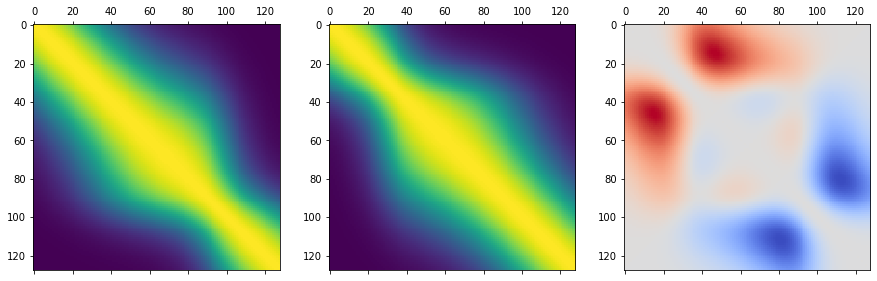

In [180]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].matshow(ps_left, cmap = plt.cm.viridis)
axs[1].matshow(ps_right, cmap = plt.cm.viridis)
axs[2].matshow(ps_diff, cmap = plt.cm.coolwarm)

In [ ]:
left_cue_row_modulation = prob_df[
    (prob_df.p_left == 0.875) *
    (prob_df.prior_modulated_likelihood == True)
].iloc[0]
right_cue_row_modulation = prob_df[
    (prob_df.p_left == 0.125) *
    (prob_df.prior_modulated_likelihood == True)
].iloc[0]
ls_left = left_cue_row_modulation.likelihood_similarity[bds[0] : bds[1], bds[0] : bds[1]]
ls_right = right_cue_row_modulation.likelihood_similarity[bds[0] : bds[1], bds[0] : bds[1]]
ls_diff = ls_left - ls_right

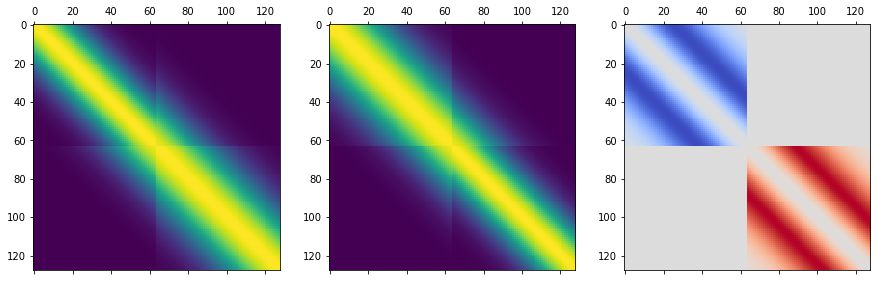

In [181]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].matshow(ls_left, cmap = plt.cm.viridis)
axs[1].matshow(ls_right, cmap = plt.cm.viridis)
axs[2].matshow(ls_diff, cmap = plt.cm.coolwarm)

In [434]:
mean_left_similarity

0.7211924945832586

In [206]:
ps_diffs = []
ls_diffs = []
for idx, row in prob_df.iterrows():
    ps = row.posterior_similarity[bds[0] : bds[1], bds[0] : bds[1]]
    half = int(len(ls)/2)
    mean_left_similarity = np.mean(ps[:half, :half])
    mean_right_similarity = np.mean(ps[half:, half:])
    mean_ps_diff = mean_left_similarity-mean_right_similarity
    
    ls = row.likelihood_similarity[bds[0] : bds[1], bds[0] : bds[1]]
    half = int(len(ls)/2)
    mean_left_similarity = np.mean(ls[:half, :half])
    mean_right_similarity = np.mean(ls[half:, half:])
    mean_ls_diff = mean_left_similarity-mean_right_similarity
    ps_diffs.append(mean_ps_diff)
    ls_diffs.append(mean_ls_diff)
prob_df['likelihood_similarity_L_minus_R'] = ls_diffs
prob_df['posterior_similarity_L_minus_R'] = ps_diffs

In [433]:
mean_left_similarity

0.7211924945832586

In [207]:
prob_df[:3]

,p_left,prior_probability,decision,posterior_probability,likelihood,likelihood_similarity,posterior_similarity,x_true,x_true_bds,x_stack,prior_modulated_likelihood,likelihood_similarity_L_minus_R,posterior_similarity_L_minus_R
0,0.125,"[0.000625, 0.000625, 0.000625, 0.000625, 0.000...","[7.804821004183249e-41, 1.8594348948735088e-40...","[[0.05265014759373285, 0.05252937674716312, 0....","[[0.052650147593732856, 0.052529376747163126, ...","[[1.0000000000000002, 0.9995587614259959, 0.99...","[[1.0, 0.9995587614259956, 0.9981849562867048,...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -188.5411190229687], [-199.0, -188.1...",True,0.118355,5.870880e-02
1,0.250,"[0.00125, 0.00125, 0.00125, 0.00125, 0.00125, ...","[6.525548079607214e-50, 1.8885725499237236e-49...","[[0.05795140588203695, 0.057789518013224066, 0...","[[0.057951405882036955, 0.05778951801322406, 0...","[[1.0000000000000002, 0.999459477601738, 0.997...","[[1.0000000000000002, 0.9994594776017381, 0.99...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -189.64682028422015], [-199.0, -189....",True,0.069082,3.540787e-02
2,0.500,"[0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.002...","[2.7648098258285257e-62, 1.0447763432550315e-6...","[[0.06443973908810857, 0.06421574225163106, 0....","[[0.06443973908810857, 0.06421574225163106, 0....","[[0.9999999999999998, 0.9993225279425012, 0.99...","[[0.9999999999999998, 0.9993225279425012, 0.99...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -190.75243171540754], [-199.0, -190....",True,0.000000,1.110223e-16


[None, None, None, None]

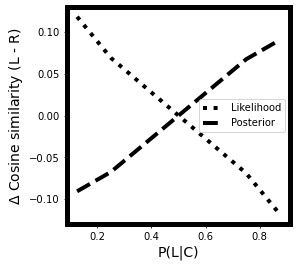

In [222]:
fig, ax = plt.subplots(figsize=(4,4))
m = prob_df.prior_modulated_likelihood==True
x = prob_df[m].p_left
y = prob_df[m].likelihood_similarity_L_minus_R
ax.plot(x,y, label = 'Likelihood', color = 'k', ls='dotted', lw=4)

m = prob_df.prior_modulated_likelihood==False
x = prob_df[m].p_left
y = prob_df[m].posterior_similarity_L_minus_R
ax.plot(x,y, label = 'Posterior', color = 'k', ls='dashed', lw=4)

ax.set_xlabel('P(L|C)', fontsize=14)
ax.set_ylabel("$\Delta$ Cosine similarity (L - R)", fontsize=14)
ax.legend()
[i.set_linewidth(5) for i in ax.spines.values()]

### samples of model prediction

In [298]:
left_cue_row_modulation = prob_df[
    (prob_df.p_left == 0.875) *
    (prob_df.prior_modulated_likelihood == True)
].iloc[0]
right_cue_row_modulation = prob_df[
    (prob_df.p_left == 0.125) *
    (prob_df.prior_modulated_likelihood == True)
].iloc[0]
ls_left = left_cue_row_modulation.likelihood_similarity[bds[0] : bds[1], bds[0] : bds[1]]
ls_right = right_cue_row_modulation.likelihood_similarity[bds[0] : bds[1], bds[0] : bds[1]]
ls_diff = ls_left - ls_right

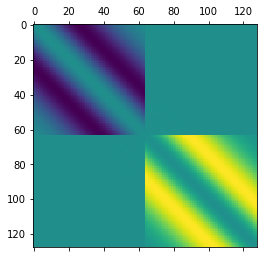

In [299]:
plt.matshow(ls_diff)

In [288]:
no_cue_row_modulation = prob_df[
    (prob_df.p_left == 0.5) *
    (prob_df.prior_modulated_likelihood == True)
].iloc[0]

(-64.0, 64.0)

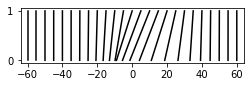

In [282]:
row = left_cue_row_modulation
fig, ax = plt.subplots(figsize=(4,1))
subsamp = 5
for i in row.x_stack[::subsamp]:
    ax.plot(i, [1, 0], color="k")
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
# axs[0].axis('off')

(-64.0, 64.0)

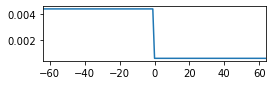

In [287]:
row = left_cue_row_modulation
fig, ax = plt.subplots(figsize=(4,1))
ax.plot(row.x_true, row.prior_probability)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])

(-64.0, 64.0)

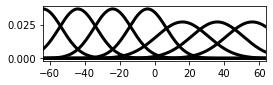

In [289]:
row = left_cue_row_modulation
fig, ax = plt.subplots(figsize=(4,1))
for i in row.likelihood[bds[0] : bds[1]][::20]:
    ax.plot(x_true, i, color="k", lw=3)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])

In [ ]:
###

(-0.5, 127.5, 127.5, -0.5)

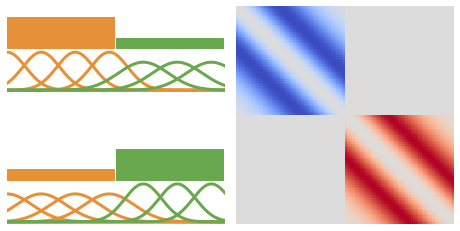

In [386]:
fig = plt.figure(constrained_layout=False, figsize=(8,4))

gs = fig.add_gridspec(nrows=5, ncols=2, hspace=0.05, wspace=0.05)
ax0 = fig.add_subplot(gs[0, 0])
# prior probability
ax = ax0
row = left_cue_row_modulation
pp = row.prior_probability * len(row.prior_probability) /2
#ax.plot(row.x_true, pp, color = 'k')
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.fill_between(np.arange(-64,0),
               np.zeros(64),
                np.ones(64)*0.75,
                color = cdcp_colors['reinforce']['L']['dark']
               )
ax.fill_between(np.arange(-0,64),
               np.zeros(64),
                np.ones(64)*0.25,
                color = cdcp_colors['reinforce']['R']['dark']
               )
ax.set_ylim([0,1])
ax.axis('off')

ax1 = fig.add_subplot(gs[1, 0])
# likelihood
ax = ax1
for i, ri in enumerate(row.likelihood[bds[0] : bds[1]]):
    if i %20 !=0:
        continue
    if i < 64:
        c = cdcp_colors['reinforce']['L']['dark']
    else:
        c = cdcp_colors['reinforce']['R']['dark']
    ax.plot(x_true, ri, color=c, lw=3)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis('off')

ax2 = fig.add_subplot(gs[3, 0])
ax = ax2
row = right_cue_row_modulation
pp = row.prior_probability * len(row.prior_probability) /2
#ax.plot(row.x_true, pp, color = 'k')
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.fill_between(np.arange(-64,0),
               np.zeros(64),
                np.ones(64)*0.25,
                color = cdcp_colors['reinforce']['L']['dark']
               )
ax.fill_between(np.arange(-0,64),
               np.zeros(64),
                np.ones(64)*0.75,
                color = cdcp_colors['reinforce']['R']['dark']
               )
ax.set_ylim([0,1])
ax.axis('off')

ax3 = fig.add_subplot(gs[4, 0])
# likelihood
ax = ax3
for i, ri in enumerate(row.likelihood[bds[0] : bds[1]]):
    if i %20 !=0:
        continue
    if i < 64:
        c = cdcp_colors['reinforce']['L']['dark']
    else:
        c = cdcp_colors['reinforce']['R']['dark']
    ax.plot(x_true, ri, color=c, lw=3)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis('off')

ax4 = fig.add_subplot(gs[:, 1])
ax = ax4
ax.matshow(ls_diff, cmap = "coolwarm")
ax.axis('off')

In [ ]:
### with posterior

In [352]:
left_cue_row_no_modulation = prob_df[
    (prob_df.p_left == 0.875) *
    (prob_df.prior_modulated_likelihood == False)
].iloc[0]
right_cue_row_no_modulation = prob_df[
    (prob_df.p_left == 0.125) *
    (prob_df.prior_modulated_likelihood == False)
].iloc[0]

ps_left = left_cue_row_no_modulation.posterior_similarity[bds[0] : bds[1], bds[0] : bds[1]]
ps_right = right_cue_row_no_modulation.posterior_similarity[bds[0] : bds[1], bds[0] : bds[1]]
ps_diff = ps_left - ps_right

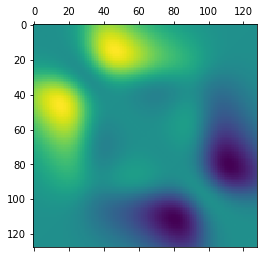

In [353]:
plt.matshow(ps_diff)

In [423]:
save_figs = True

(-0.5, 127.5, 127.5, -0.5)

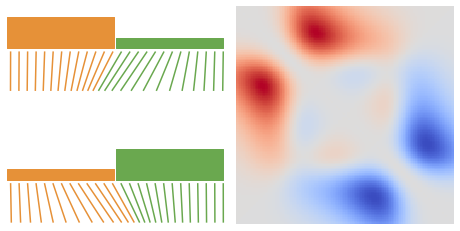

In [384]:
fig = plt.figure(constrained_layout=False, figsize=(8,4))

gs = fig.add_gridspec(nrows=5, ncols=2, hspace=0.05, wspace=0.05)
ax0 = fig.add_subplot(gs[0, 0])
# prior probability
ax = ax0
row = left_cue_row_modulation
pp = row.prior_probability * len(row.prior_probability) /2
#ax.plot(row.x_true, pp, color = 'k')
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.fill_between(np.arange(-64,0),
               np.zeros(64),
                np.ones(64)*0.75,
                color = cdcp_colors['reinforce']['L']['dark']
               )
ax.fill_between(np.arange(-0,64),
               np.zeros(64),
                np.ones(64)*0.25,
                color = cdcp_colors['reinforce']['R']['dark']
               )
ax.set_ylim([0,1])
ax.axis('off')

ax1 = fig.add_subplot(gs[1, 0])
ax = ax1
row = left_cue_row_no_modulation
subsamp = 5
for i in row.x_stack[8:][::subsamp]:
    if i[0] < 0:
        color = cdcp_colors['reinforce']['L']['dark']
    else:
        color = cdcp_colors['reinforce']['R']['dark']
    ax.plot(i, [1, 0], color=color)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis('off')



ax2 = fig.add_subplot(gs[3, 0])
ax = ax2
row = right_cue_row_modulation
pp = row.prior_probability * len(row.prior_probability) /2
#ax.plot(row.x_true, pp, color = 'k')
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.fill_between(np.arange(-64,0),
               np.zeros(64),
                np.ones(64)*0.25,
                color = cdcp_colors['reinforce']['L']['dark']
               )
ax.fill_between(np.arange(-0,64),
               np.zeros(64),
                np.ones(64)*0.75,
                color = cdcp_colors['reinforce']['R']['dark']
               )
ax.set_ylim([0,1])
ax.axis('off')

ax3 = fig.add_subplot(gs[4, 0])
ax = ax3
row = right_cue_row_no_modulation
subsamp = 5
for i in row.x_stack[8:][::subsamp]:
    if i[0] < 0:
        color = cdcp_colors['reinforce']['L']['dark']
    else:
        color = cdcp_colors['reinforce']['R']['dark']
    ax.plot(i, [1, 0], color=color)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis('off')
ax4 = fig.add_subplot(gs[:, 1])
ax = ax4
ax.matshow(ps_diff, cmap = "coolwarm")
ax.axis('off')

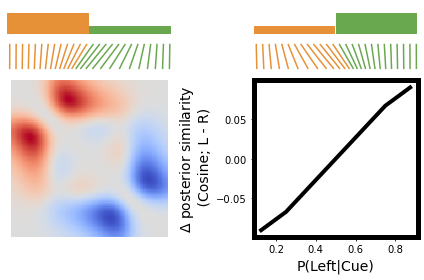

In [430]:
f, axs = plt.subplots(
    3, 2, gridspec_kw={"height_ratios": [1, 1, 6], "width_ratios": [1, 1]}
)

ax = axs[0, 0]
row = left_cue_row_modulation
pp = row.prior_probability * len(row.prior_probability) / 2
# ax.plot(row.x_true, pp, color = 'k')
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.fill_between(
    np.arange(-64, 0),
    np.zeros(64),
    np.ones(64) * 0.75,
    color=cdcp_colors["reinforce"]["L"]["dark"],
)
ax.fill_between(
    np.arange(-0, 64),
    np.zeros(64),
    np.ones(64) * 0.25,
    color=cdcp_colors["reinforce"]["R"]["dark"],
)
ax.set_ylim([0, 1])
ax.axis("off")

ax = axs[1,0]
row = left_cue_row_no_modulation
subsamp = 5
for i in row.x_stack[8:][::subsamp]:
    if i[0] < 0:
        color = cdcp_colors["reinforce"]["L"]["dark"]
    else:
        color = cdcp_colors["reinforce"]["R"]["dark"]
    ax.plot(i, [1, 0], color=color)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis("off")


ax = axs[0,1]
row = right_cue_row_modulation
pp = row.prior_probability * len(row.prior_probability) / 2
# ax.plot(row.x_true, pp, color = 'k')
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.fill_between(
    np.arange(-64, 0),
    np.zeros(64),
    np.ones(64) * 0.25,
    color=cdcp_colors["reinforce"]["L"]["dark"],
)
ax.fill_between(
    np.arange(-0, 64),
    np.zeros(64),
    np.ones(64) * 0.75,
    color=cdcp_colors["reinforce"]["R"]["dark"],
)
ax.set_ylim([0, 1])
ax.axis("off")

ax = axs[1, 1]
row = right_cue_row_no_modulation
subsamp = 5
for i in row.x_stack[8:][::subsamp]:
    if i[0] < 0:
        color = cdcp_colors["reinforce"]["L"]["dark"]
    else:
        color = cdcp_colors["reinforce"]["R"]["dark"]
    ax.plot(i, [1, 0], color=color)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis("off")

ax = axs[2,0]
ax.matshow(ps_diff, cmap="coolwarm")
ax.axis("off")

ax = axs[2,1]

ax.set_ylabel("$\Delta$ posterior similarity\n (Cosine; L - R)", fontsize=14)
ax.set_xlabel('P(Left|Cue)', fontsize=14)
#ax.axis("off")
m = prob_df.prior_modulated_likelihood==False
x = prob_df[m].p_left
y = prob_df[m].posterior_similarity_L_minus_R
ax.plot(x,y, label = 'Posterior', color = 'k', lw=4)
[i.set_linewidth(5) for i in ax.spines.values()]
plt.tight_layout()

ensure_dir(FIGURE_DIR / 'likelihood_model')
if save_figs:
    save_fig(FIGURE_DIR / 'likelihood_model'/ 'posterior_shift', save_pdf=True)
plt.show()


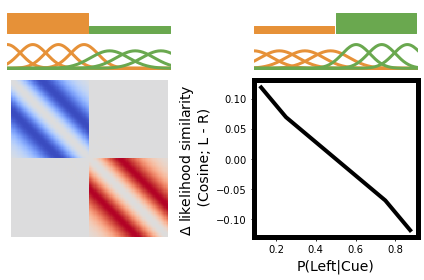

In [431]:
f, axs = plt.subplots(
    3, 2, gridspec_kw={"height_ratios": [1, 1, 6], "width_ratios": [1, 1]}
)

ax = axs[0, 0]
row = left_cue_row_modulation
pp = row.prior_probability * len(row.prior_probability) / 2
# ax.plot(row.x_true, pp, color = 'k')
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.fill_between(
    np.arange(-64, 0),
    np.zeros(64),
    np.ones(64) * 0.75,
    color=cdcp_colors["reinforce"]["L"]["dark"],
)
ax.fill_between(
    np.arange(-0, 64),
    np.zeros(64),
    np.ones(64) * 0.25,
    color=cdcp_colors["reinforce"]["R"]["dark"],
)
ax.set_ylim([0, 1])
ax.axis("off")

ax = axs[1,0]
row = left_cue_row_modulation
# likelihood
for i, ri in enumerate(row.likelihood[bds[0] : bds[1]]):
    if i %20 !=0:
        continue
    if i < 64:
        c = cdcp_colors['reinforce']['L']['dark']
    else:
        c = cdcp_colors['reinforce']['R']['dark']
    ax.plot(x_true, ri, color=c, lw=3)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis('off')

ax = axs[0,1]
row = right_cue_row_modulation
pp = row.prior_probability * len(row.prior_probability) / 2
# ax.plot(row.x_true, pp, color = 'k')
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.fill_between(
    np.arange(-64, 0),
    np.zeros(64),
    np.ones(64) * 0.25,
    color=cdcp_colors["reinforce"]["L"]["dark"],
)
ax.fill_between(
    np.arange(-0, 64),
    np.zeros(64),
    np.ones(64) * 0.75,
    color=cdcp_colors["reinforce"]["R"]["dark"],
)
ax.set_ylim([0, 1])
ax.axis("off")

ax = axs[1, 1]
# likelihood
for i, ri in enumerate(row.likelihood[bds[0] : bds[1]]):
    if i %20 !=0:
        continue
    if i < 64:
        c = cdcp_colors['reinforce']['L']['dark']
    else:
        c = cdcp_colors['reinforce']['R']['dark']
    ax.plot(x_true, ri, color=c, lw=3)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis('off')

ax = axs[2,0]
ax.matshow(ls_diff, cmap="coolwarm")
ax.axis("off")

ax = axs[2,1]

ax.set_ylabel("$\Delta$ likelihood similarity\n (Cosine; L - R)", fontsize=14)
ax.set_xlabel('P(Left|Cue)', fontsize=14)
#ax.axis("off")
m = prob_df.prior_modulated_likelihood==True
x = prob_df[m].p_left
y = prob_df[m].likelihood_similarity_L_minus_R
ax.plot(x,y, label = 'Likelihood', color = 'k', lw=4)
[i.set_linewidth(5) for i in ax.spines.values()]
plt.tight_layout()

ensure_dir(FIGURE_DIR / 'likelihood_model')
if save_figs:
    save_fig(FIGURE_DIR / 'likelihood_model'/ 'likelihood_shift', save_pdf=True)
plt.show()


### get similarity by cue probability relative to mean

In [435]:
prob_df[:3]

,p_left,prior_probability,decision,posterior_probability,likelihood,likelihood_similarity,posterior_similarity,x_true,x_true_bds,x_stack,prior_modulated_likelihood,likelihood_similarity_L_minus_R,posterior_similarity_L_minus_R
0,0.125,"[0.000625, 0.000625, 0.000625, 0.000625, 0.000...","[7.804821004183249e-41, 1.8594348948735088e-40...","[[0.05265014759373285, 0.05252937674716312, 0....","[[0.052650147593732856, 0.052529376747163126, ...","[[1.0000000000000002, 0.9995587614259959, 0.99...","[[1.0, 0.9995587614259956, 0.9981849562867048,...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -188.5411190229687], [-199.0, -188.1...",True,0.118355,5.870880e-02
1,0.250,"[0.00125, 0.00125, 0.00125, 0.00125, 0.00125, ...","[6.525548079607214e-50, 1.8885725499237236e-49...","[[0.05795140588203695, 0.057789518013224066, 0...","[[0.057951405882036955, 0.05778951801322406, 0...","[[1.0000000000000002, 0.999459477601738, 0.997...","[[1.0000000000000002, 0.9994594776017381, 0.99...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -189.64682028422015], [-199.0, -189....",True,0.069082,3.540787e-02
2,0.500,"[0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.002...","[2.7648098258285257e-62, 1.0447763432550315e-6...","[[0.06443973908810857, 0.06421574225163106, 0....","[[0.06443973908810857, 0.06421574225163106, 0....","[[0.9999999999999998, 0.9993225279425012, 0.99...","[[0.9999999999999998, 0.9993225279425012, 0.99...","[-200, -199, -198, -197, -196, -195, -194, -19...","[-64, 64]","[[-200.0, -190.75243171540754], [-199.0, -190....",True,0.000000,1.110223e-16


In [499]:
poserior_mean = np.mean(prob_df[
    (prob_df.prior_modulated_likelihood == False) & (prob_df.p_left == 0.5)
].posterior_similarity.values[0][bds[0] : bds[1], bds[0] : bds[1]][:64, :64])
likelihood_mean = np.mean(prob_df[
    (prob_df.prior_modulated_likelihood == True) & (prob_df.p_left == 0.5)
].likelihood_similarity.values[0][bds[0] : bds[1], bds[0] : bds[1]][:64, :64])
poserior_mean, likelihood_mean

(0.7211924945832586, 0.5235467377590536)

In [507]:
p_cue = []
posterior_mean_relative = []
likelihood_mean_relative = []
for p_l in [0.125, 0.25, 0.75, 0.875]:
    likelihood_m = (prob_df.prior_modulated_likelihood == True) & (prob_df.p_left == p_l)
    posterior_m = (prob_df.prior_modulated_likelihood == False) & (prob_df.p_left == p_l)
    posterior = prob_df[posterior_m].posterior_similarity.values[0][bds[0] : bds[1], bds[0] : bds[1]]
    likelihood = prob_df[likelihood_m].likelihood_similarity.values[0][bds[0] : bds[1], bds[0] : bds[1]]
    L_posterior = np.nanmean(posterior[:64, : 64])
    R_posterior = np.nanmean(posterior[64:, 64:])
    L_likelihood = np.nanmean(likelihood[:64, : 64])
    R_likelihood = np.nanmean(likelihood[64:, 64:])
    p_cue.append(p_l)
    posterior_mean_relative.append(L_posterior - poserior_mean)
    likelihood_mean_relative.append(L_likelihood - likelihood_mean)

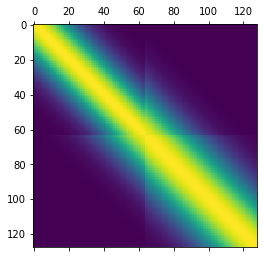

In [508]:
plt.matshow(likelihood)

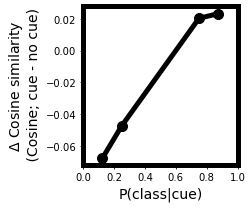

In [524]:
fig, ax = plt.subplots(figsize=(3.5,3))
ax.set_ylabel("$\Delta$ Cosine similarity\n (Cosine; cue - no cue)", fontsize=14)
ax.set_xlabel('P(class|cue)', fontsize=14)
#ax.axis("off")
ax.plot(p_cue, posterior_mean_relative, color = 'k', lw = 5)
ax.scatter(p_cue, posterior_mean_relative, color = 'k', s = 100)
[i.set_linewidth(5) for i in ax.spines.values()]
plt.tight_layout()
ax.set_xlim([0, 1])
ensure_dir(FIGURE_DIR / 'likelihood_model')
if save_figs:
    save_fig(FIGURE_DIR / 'likelihood_model'/ 'posterior_shift_by_cue_prob', save_pdf=True)
plt.show()

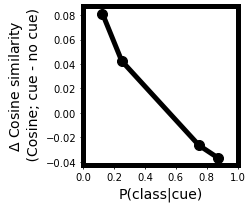

In [526]:
fig, ax = plt.subplots(figsize=(3.5,3))
ax.set_ylabel("$\Delta$ Cosine similarity\n (Cosine; cue - no cue)", fontsize=14)
ax.set_xlabel('P(class|cue)', fontsize=14)
#ax.axis("off")
ax.plot(p_cue, likelihood_mean_relative, color = 'k', lw = 5)
ax.scatter(p_cue, likelihood_mean_relative, color = 'k', s = 100)
[i.set_linewidth(5) for i in ax.spines.values()]
plt.tight_layout()
ax.set_xlim([0, 1])
ensure_dir(FIGURE_DIR / 'likelihood_model')
if save_figs:
    save_fig(FIGURE_DIR / 'likelihood_model'/ 'likelihood_shift_by_cue_prob', save_pdf=True)
plt.show()

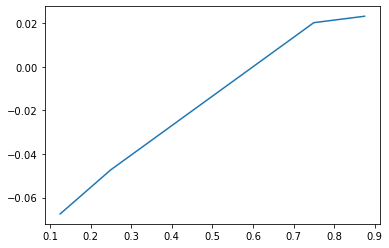

In [509]:
plt.plot(p_cue, posterior_mean_relative)
#plt.plot(p_cue, likelihood_mean_relative)

In [449]:
posterior.shape

(400, 400)

In [474]:
L_posterior

0.008225963993945564

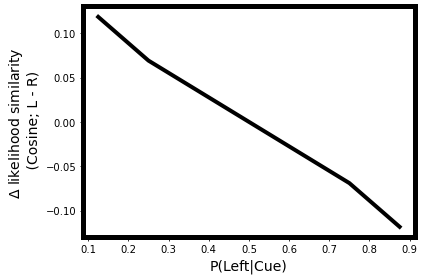

In [432]:
fig, ax = plt.subplots()
ax.set_ylabel("$\Delta$ likelihood similarity\n (Cosine; L - R)", fontsize=14)
ax.set_xlabel('P(Left|Cue)', fontsize=14)
#ax.axis("off")
m = prob_df.prior_modulated_likelihood==True
x = prob_df[m].p_left
y = prob_df[m].likelihood_similarity_L_minus_R
ax.plot(x,y, label = 'Likelihood', color = 'k', lw=4)
[i.set_linewidth(5) for i in ax.spines.values()]
plt.tight_layout()